## Planning in Artificial Intelligence (MAC5788)
### EP1 - Easy21 Control

GitHub: https://github.com/RenatoGeh/mac5788/tree/master/ep1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange

from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

A card is represented by a number. Let $n$ be a card, and let

\begin{equation}
    \mathbb{Z}^{[a, b]} = \{x\in\mathbb{Z}|a\leq x\leq b\}.
\end{equation}

The value of $n$ is defined by:

\begin{align}
    n \in \begin{cases}
        \mathbb{Z}^{[1,10]} &\text{, if $n$ is a black card;}\\
        \mathbb{Z}^{[-1,-10]} &\text{, if $n$ is a red card.}
    \end{cases}
\end{align}

As per the assignment's description, cards are sampled by a uniform distribution, with probability $1/3$ of picking red, and $2/3$ of black.

In [2]:
RAND_SEED = 1001

# Set global seed.
np.random.seed(RAND_SEED)

# Samples n cards following the above description.
def sample_card(n = None):
    # Probabilities (1/3 for red, 2/3 for black).
    P = np.random.choice([-1, 1], size=n, p=[1/3, 2/3])
    # Samples from a uniform distribution in range [1, 10]
    S = np.random.randint(0, 10, size=n)+1
    return P*S

# Samples initial cards (only black).
def sample_initial_card(n = None):
    return np.random.randint(0, 10, size=n)+1

# Samples dealer turns until stick. Returns -1, 0 or 1 if
# game is lost, drew or won (for player).
#
# IMPORTANT ASSUMPTION:
# The assignment does not specify whether game conditions are
# checked statically (always being checked) or only after the
# next card draw. We assume the latter.
def sample_dealer(d, p):
    old_d = d
    s = State(old_d, p, True)
    while True:
        c = sample_card()
        d += c
        if d < 1 or d > 21:
            return 1, s
        if d >= 17:
            if d > p:
                return -1, s
            if d < p:
                return 1, s
            return 0, s

Let $S$ be a State. We define $S$ as a tuple $(d, p, t)$, where $d$ is the dealer's first card, and $p$ the player's sum. The last argument $t$ indicates whether this is a terminal state.

In [3]:
class State:    
    # State's constructor.
    # d - dealer's card   (integer)
    # p - player's sum    (integer)
    # t - terminal state? (boolean)
    def __init__(self, d = None, p = None, t = False):
        self.d = sample_initial_card() if d is None else d
        self.p = sample_initial_card() if p is None else p
        self.t = t

    # Samples the next state.
    def sample_next(self):
        c = sample_card()
        p = self.p + c
        s = State(self.d, p)
        r = -1 if s.lost() else 0
        return r, s
    
    def _is_terminal(self):
        return True if self.p < 1 or self.p > 21 else False
    
    def lost(self):
        self.t = self._is_terminal()
        return self.t

    def copy(self):
        return State(self.d, self.p, self.t)
    
    # Defines equality between states.
    def __eq__(self, s):
        if not isinstance(s, State):
            return False
        return self.d == s.d and self.p == s.p

    # Hash
    def __hash__(self):
        h = int(51*(self.p+20)+self.d+10)
        return h
    
    def __str__(self):
        return "({}, {}, {})".format(self.d, self.p, self.t)
    
    def __repr__(self):
        return self.__str__()

    @staticmethod
    def Restricted():
        return State()
    
    @staticmethod
    def Unrestricted():
        return State(sample_card(), sample_card())
    
    @staticmethod
    def FromHash(h):
        d = int(h % 51 - 10)
        p = round((h-d)/51 - 20)
        s = State(d, p)
        s.lost()
        return s
    
    @staticmethod
    def NumberStates():
        return 52*21
    
    @staticmethod
    def MaxHash():
        # 51*(31+20)+10+10=2621
        return 2621 # that's prime btw :)
    
    @staticmethod
    def NewStates(t=float):
        return dict.fromkeys(range(0, State.NumberStates()+1), 
                             0 if t == int else 0.0)
    
    @staticmethod
    def Axes(a = None):
        axes = (52, 21)
        if a is None:
            return axes
        return axes[a]
    
    @staticmethod
    def HashToArray(H):
        A = np.zeros(State.NumberStates())
        i = 0
        for k in H:
            A[i] = H[k]
            i += 1
        return A

Although we define the two policies used in prediction, we don't really use them.

In [4]:
# Actions
STICK = 0
HIT = 1
ACTIONS = [STICK, HIT]

# First policy:
#   Always hit when s.p < 20.
#   Always stick otherwise.
def policy_1(s):
    if s.p < 20:
        return [0.0, 1.0]
    return [1.0, 0.0]

# Second policy:
#   Always hit when s.p < 17.
#   Randomly hit or stick otherwise.
def policy_2(s):
    if s.p < 17:
        return [0.0, 1.0]
    return [0.5, 0.5]

# Samples policy pi given state s.
def sample_action(s, pi):
    P = pi(s) if callable(pi) else pi[s]
    return np.random.choice(ACTIONS, p=P)

Function $\texttt{STEP}$ is defined as specified in the assignment.

In [5]:
# STEP takes a state-action pair, and returns a reward and the
# sample next state.
def STEP(s, a):
    if a == STICK:
        if s.lost():
            return -1, s
        return sample_dealer(s.d, s.p)
    return s.sample_next()

We now define an episode and how to generate/sample them.

In [6]:
# A SAR defines a triple (s, a, r), where s is a state, a is an
# action and r is a reward.
class SAR:
    # SAR's constructor:
    #  s - state
    #  a - action
    #  r - reward
    def __init__(self, s, a, r):
        self.s = s
        self.a = a
        self.r = r

    # A SAR p is equal to another SAR q iff their states are
    # identical.
    def __eq__(self, sar):
        if not isinstance(sar, SAR):
            return False
        return self.s == sar.s
    
    def __str__(self):
        return "({}, {}, {})".format(self.s, self.a, self.r)
    
    def __repr__(self):
        return self.__str__()

# Generates an episode under policy pi.
def gen_episode(pi, restrict=True):
    E = []
    if restrict:
        s = State()
    else:
        s = State(sample_card(), sample_card())
    while not s.t:
        a = sample_action(s, pi)
        n_r, n_s = STEP(s, a)
        E.append(SAR(s, a, n_r))
        s = n_s
    E[-1].s.t = True
    return E


Help functions for plotting graphs:

In [7]:
# Plots a scatter plot.
def draw_scatter(V, fig = None, pos = 111):
    if fig is None:
        fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(pos, projection='3d')

    for h, v in V.items():
        s = State.FromHash(h)
        ax.scatter(s.d, s.p, v)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('State values')

    if fig is None:
        plt.show()

# Plots a surface with trisurf.
def draw_trisurf(V, fig = None, pos = 111):
    if fig is None:
        fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(pos, projection='3d')

    x_data = []
    y_data = []
    z_data = []

    for h, v in V.items():
        s = State.FromHash(h)
        x_data.append(s.d)
        y_data.append(s.p)
        z_data.append(v)

    ax.plot_trisurf(x_data, y_data, z_data, alpha=0.5, antialiased=True)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('State values')
    fig.tight_layout()

    if fig is None:
        plt.show()
    
def draw_scatter_trisurf(V):
    fig = plt.figure(figsize=(20, 10))
    draw_scatter(V, fig, 121)
    draw_trisurf(V, fig, 122)
    plt.show()
    
# Plots a surface with wireframe.
def draw_wireframe(V):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    n = State.NumberStates()
    
    x_data, y_data, z_data = np.zeros(n), np.zeros(n), np.zeros(n)

    i = 0
    for h, v in V.items():
        s = State.FromHash(h)
        x_data[i] = s.d
        y_data[i] = s.p
        z_data[i] = v
        i += 1

    A = State.Axes()
    ax.plot_wireframe(np.array(x_data).reshape(A),
                      np.array(y_data).reshape(A),
                      np.array(z_data).reshape(A))
    
    plt.show()

#### Monte-Carlo Control

Computing first-visit MC...


Number of episodes: 100


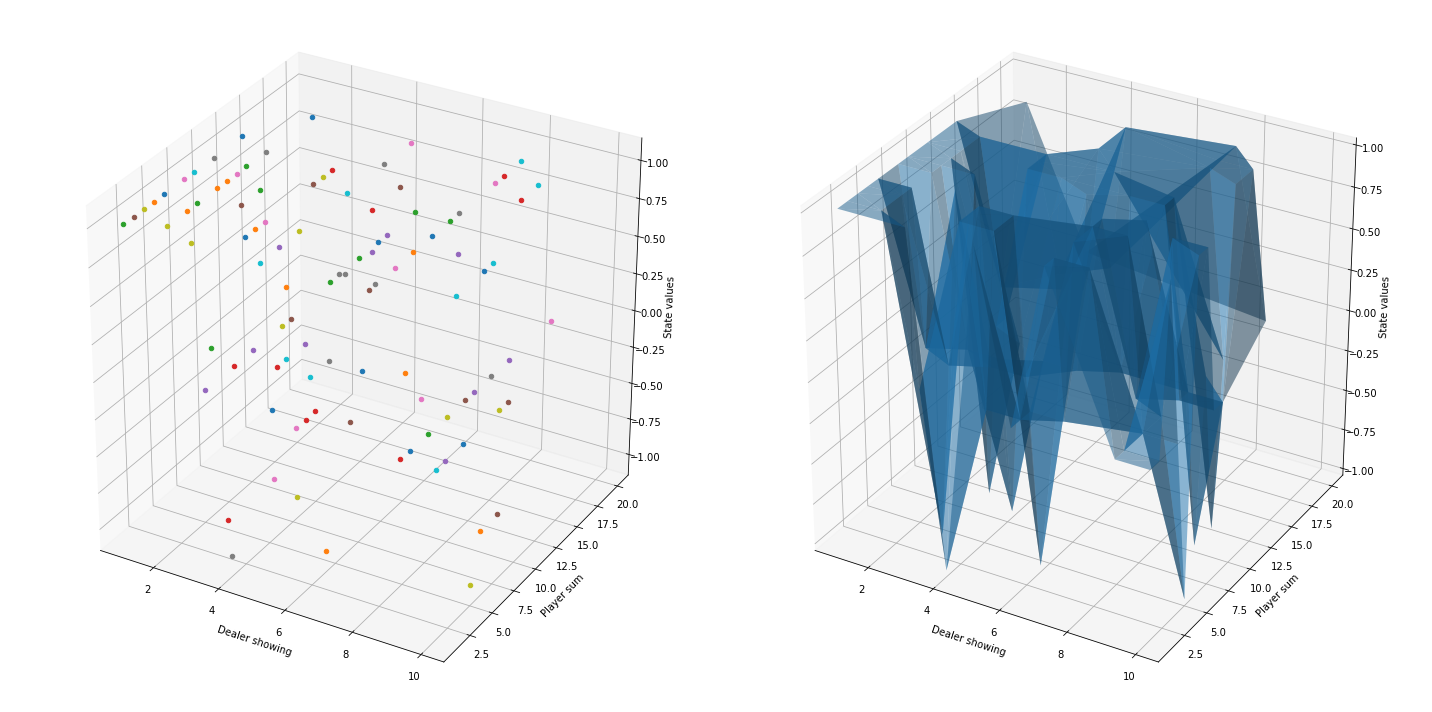

Number of episodes: 1000


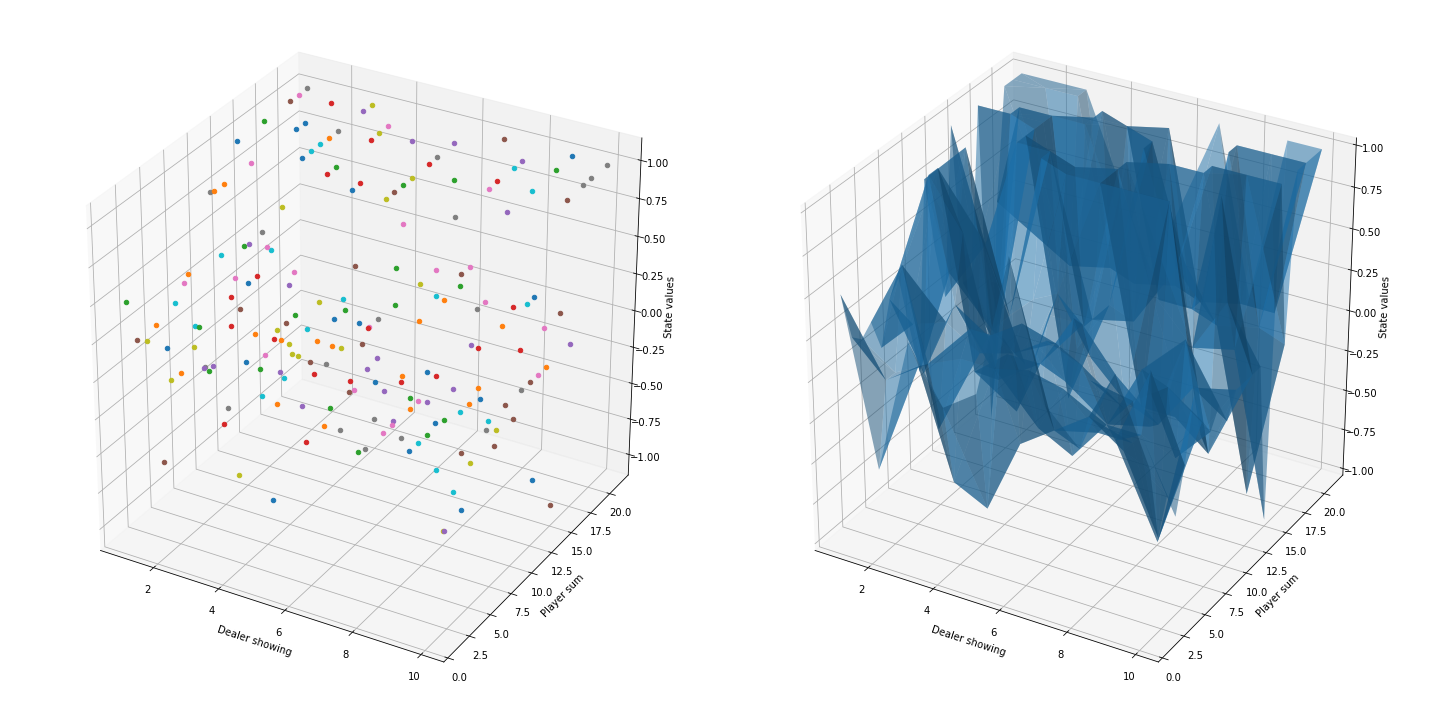

Number of episodes: 10000


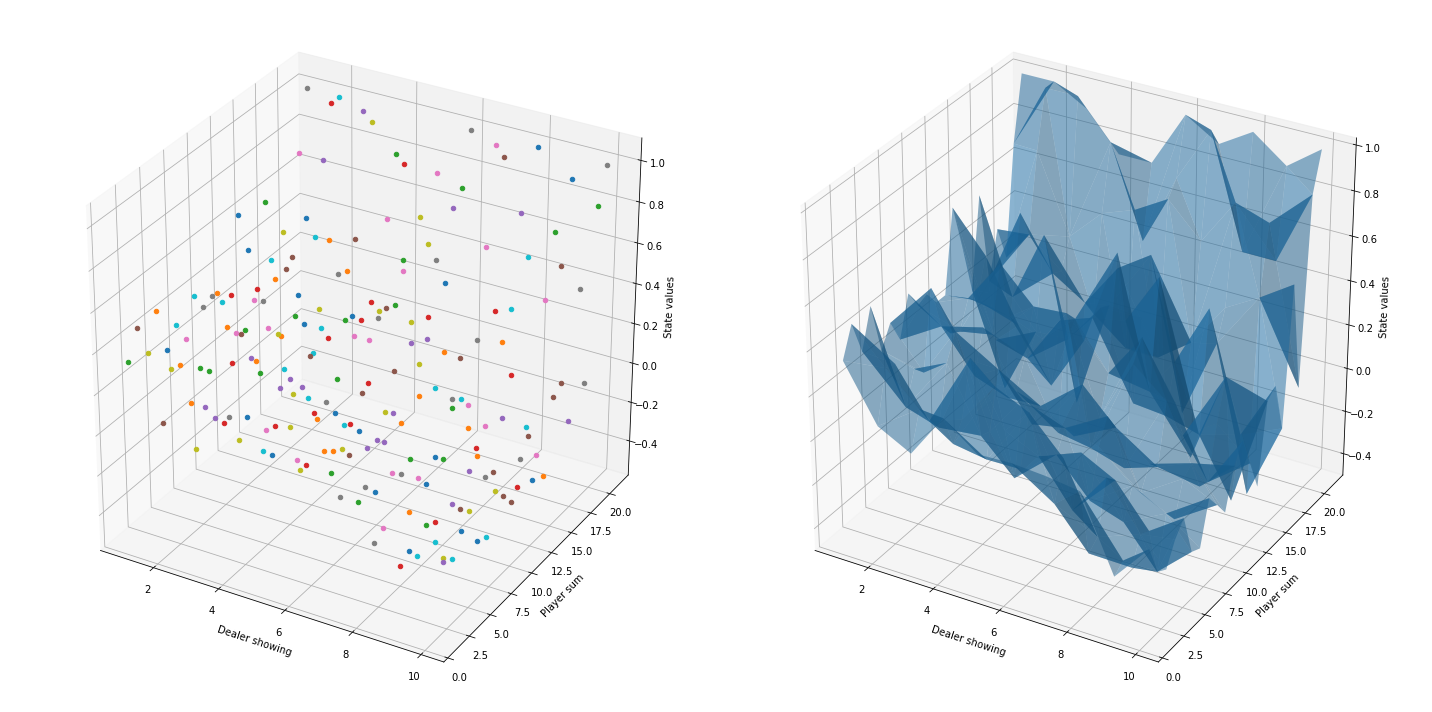

Number of episodes: 100000


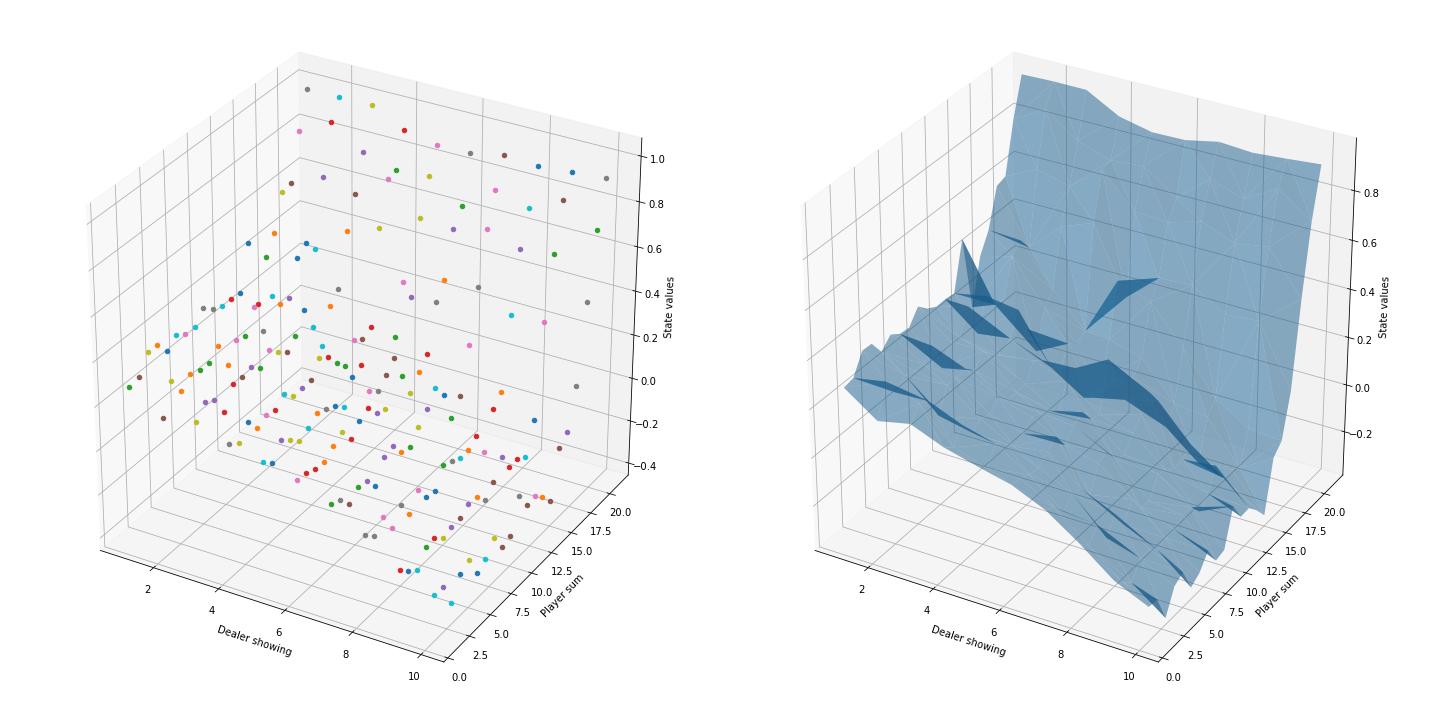


Computing every-visit MC...


Number of episodes: 100


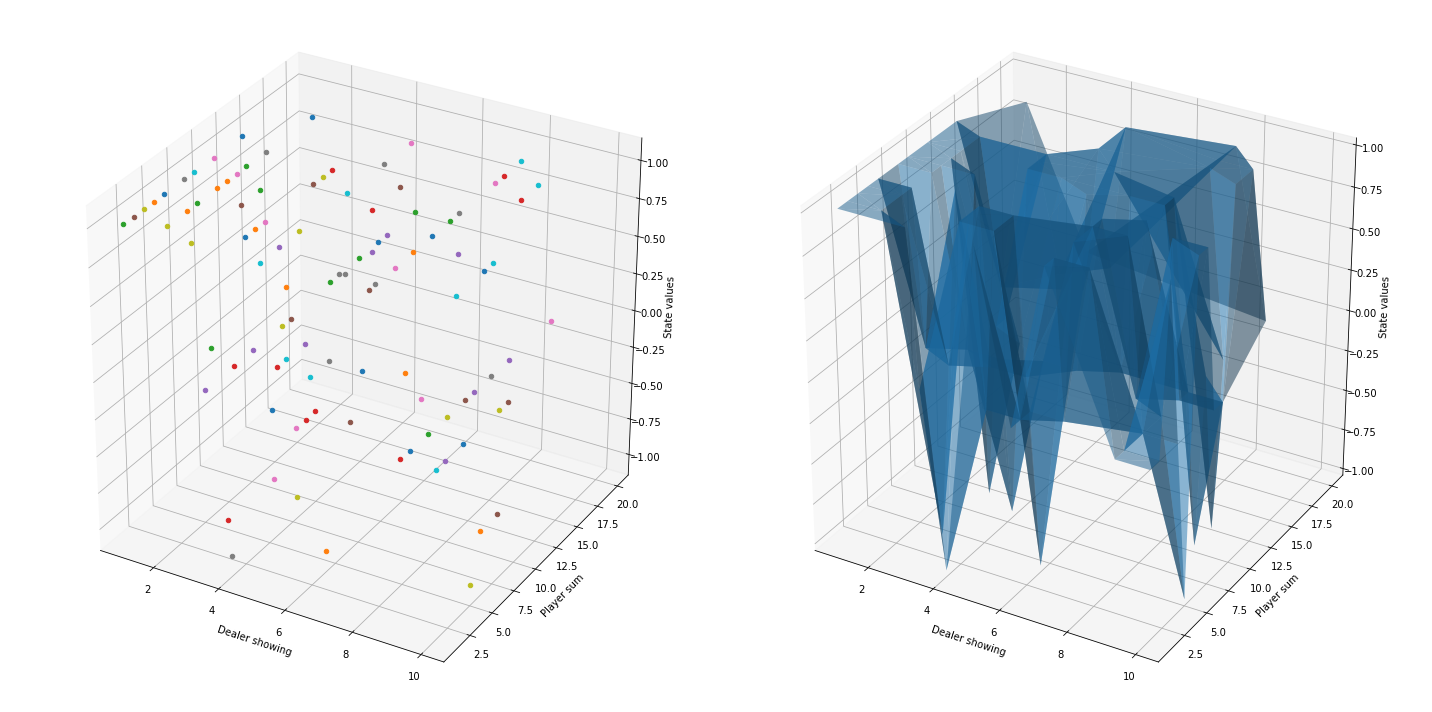

Number of episodes: 1000


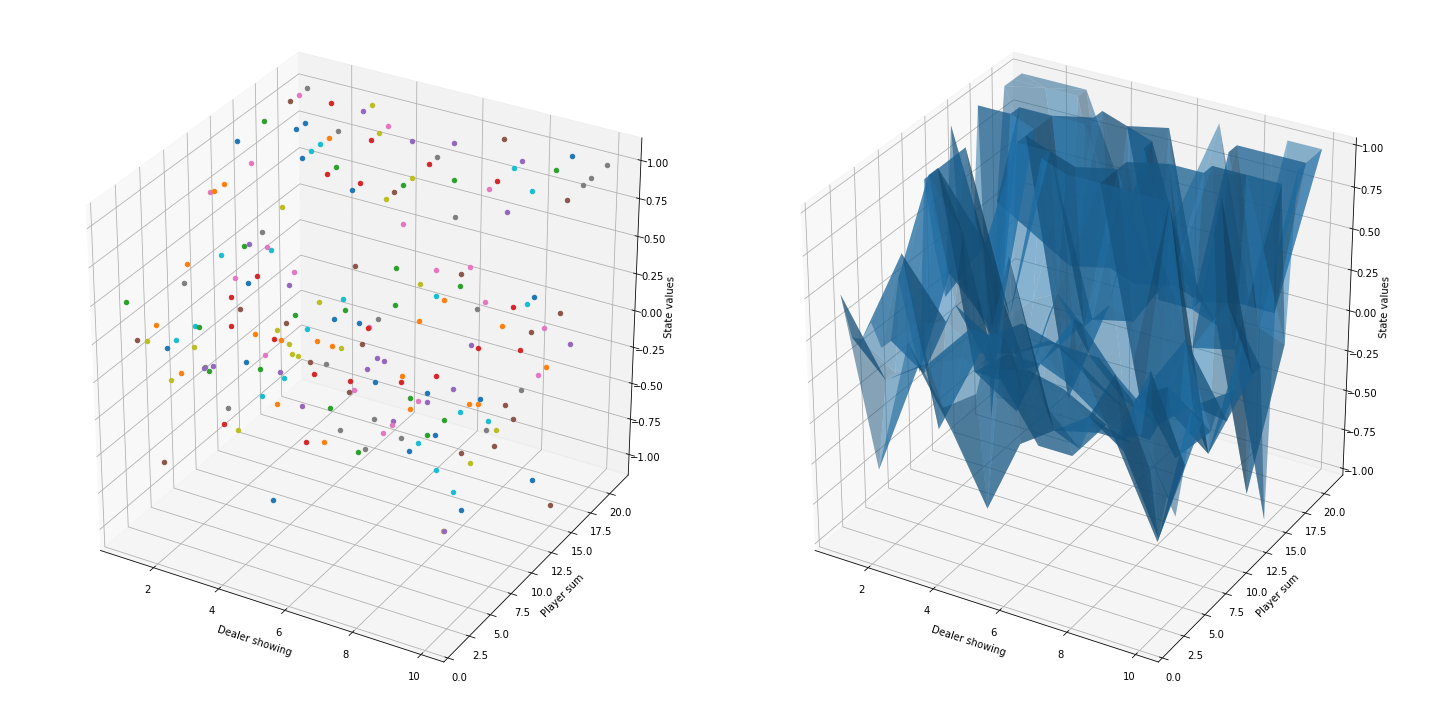

Number of episodes: 10000


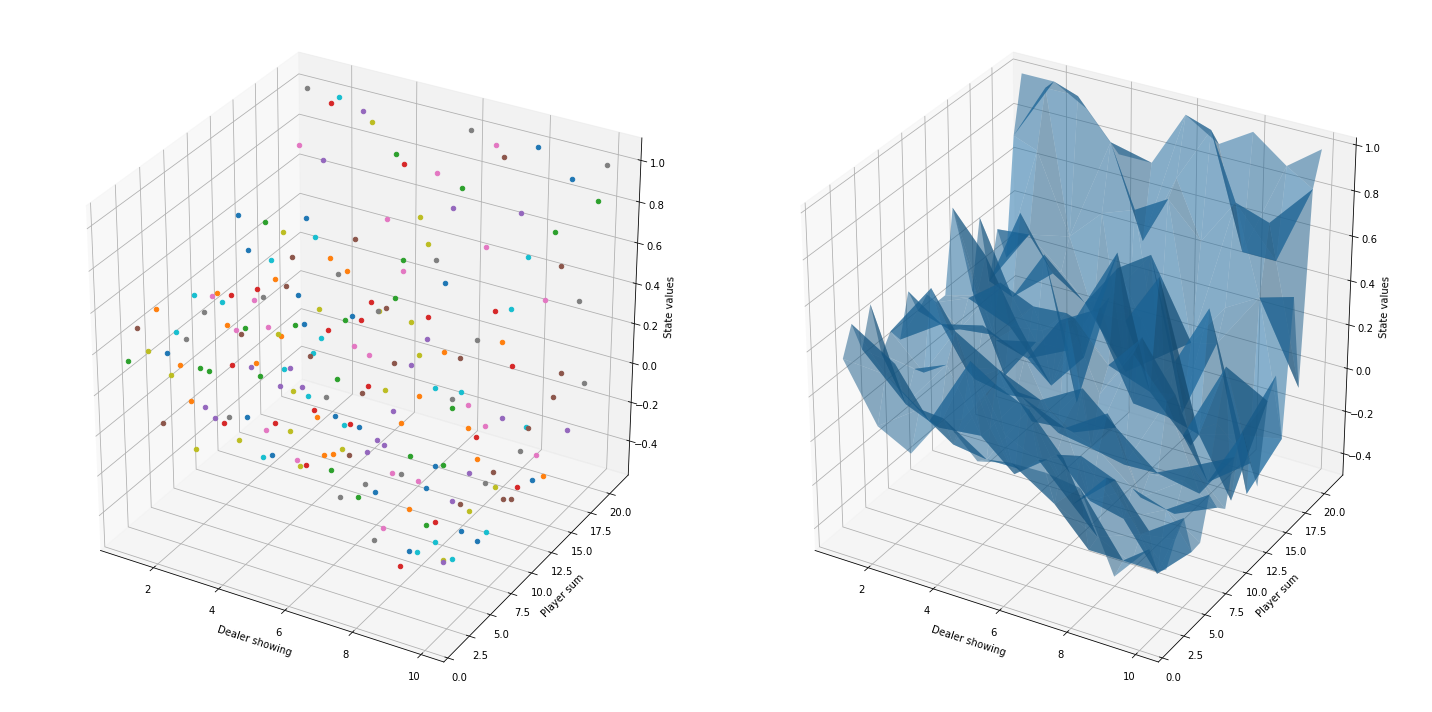

Number of episodes: 100000


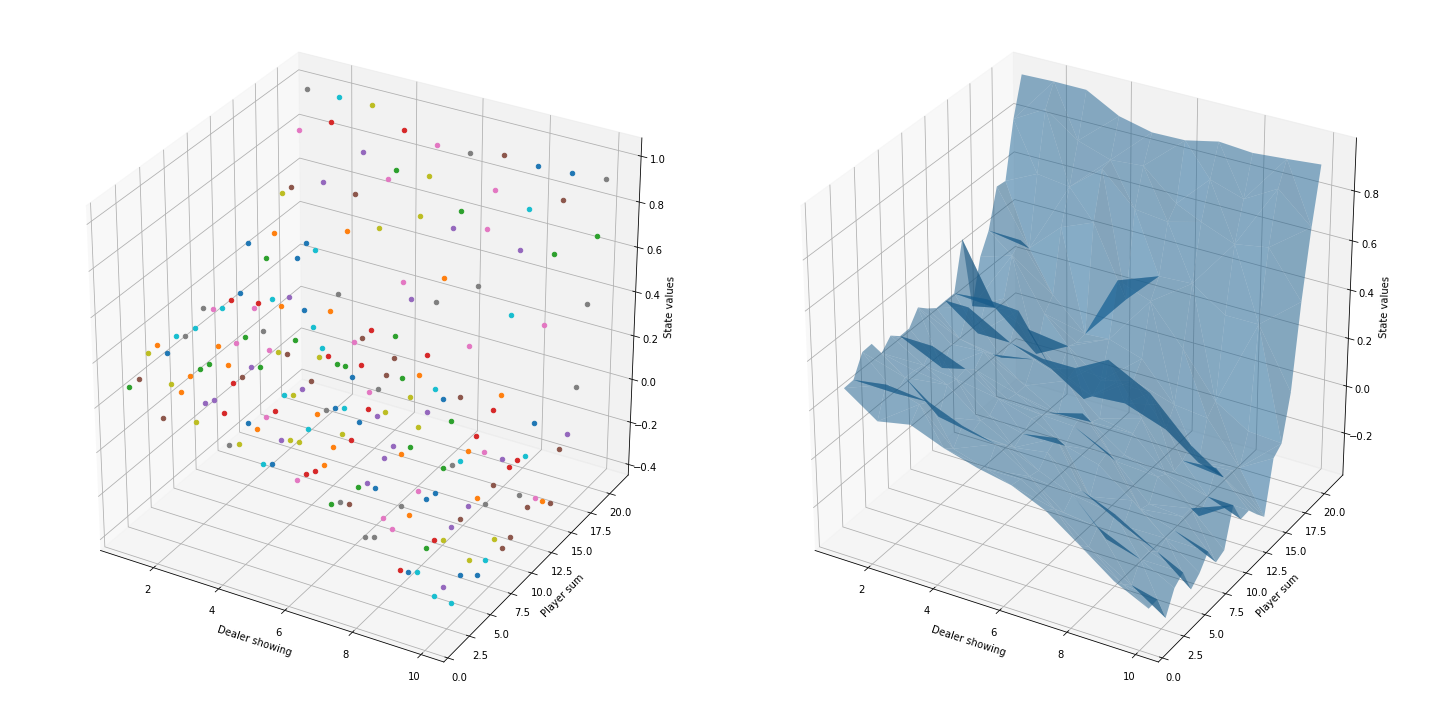

In [8]:
N_0 = 100

# Monte-Carlo Control
#   n     - number of episodes to run
#   gamma - discount rate
#   mode  - either 'first'-visit or every-visit
def mc_control(n=1000, gamma=1, mode='first', restrict=True, foreach=None):
    np.random.seed(RAND_SEED)
    Q = defaultdict(lambda: [0, 0])
    M = defaultdict(int) # counting over states
    N = defaultdict(lambda: [0, 0]) # counting over state-action pairs
    pi = defaultdict(lambda: [0.5, 0.5])
    for i in tnrange(n, desc="Progress"):
        E = gen_episode(pi, restrict)
        G = 0
        for t, sar in reversed(list(enumerate(E))):
            G = gamma*G + sar.r
            s, a = hash(sar.s), sar.a
            if mode != 'first' or sar not in E[0:t]:
                N[s][a] += 1
                Q[s][a] += (G-Q[s][a])/N[s][a]
                eps = N_0/(N_0+M[s])
                M[s] += 1
                a_o = np.argmax(Q[s])
                p_o = 1.0-eps/2
                p_no = 1.0-p_o
                for a_i in ACTIONS:
                    pi[s][a_i] = p_o if a_i == a_o else p_no
        if foreach is not None:
            foreach(i, Q)
    return Q

def extract_max_V(Q):
    V = defaultdict(float)
    for k in Q:
        V[k] = max(Q[k])
    return V

def draw_values_policy(Q, restrict=False):
    print("State value function:")
    draw_scatter_trisurf(extract_max_V(Q))
    print("Policy:")
    domain = (22, 11) if restrict else (52, 21) 
    P = np.zeros(domain)
    P -= 1
    for h in Q:
        s = State.FromHash(h)
        P[s.p,s.d] = np.argmax(Q[h])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(P)
    plt.show()

def plot_at_each(n, Q):
    if n == 100 or n == 1000 or n == 10000 or n == 100000:
        print("Number of episodes: {:}".format(n))
        draw_scatter_trisurf(extract_max_V(Q))

MC_N = 1000000

print('Computing first-visit MC...')
mc_Q = mc_control(MC_N, foreach=plot_at_each)
mc_V = extract_max_V(mc_Q)

print('Computing every-visit MC...')
mc_e_Q = mc_control(MC_N, mode='every', foreach=plot_at_each)
mc_e_V = extract_max_V(mc_e_Q)

Above are the plots for $V(s):=\max_a Q(s,a)$ for each number of episodes. We can clearly see the function start to "smooth" the more episodes we complete.

The policies generated by `mc_control` are optimal. Below we plot the values of $V(s):=\max_a Q(s,a)$ for both policies constrained to only positive initial cards (i.e. no negative starting values for dealer or player). We call this case the *restricted* case. The unrestricted case allows negative starting values.

Here's the plot for the optimal restricted case Monte-Carlo methods:

Optimal policy for the restricted case on first-visit MC:


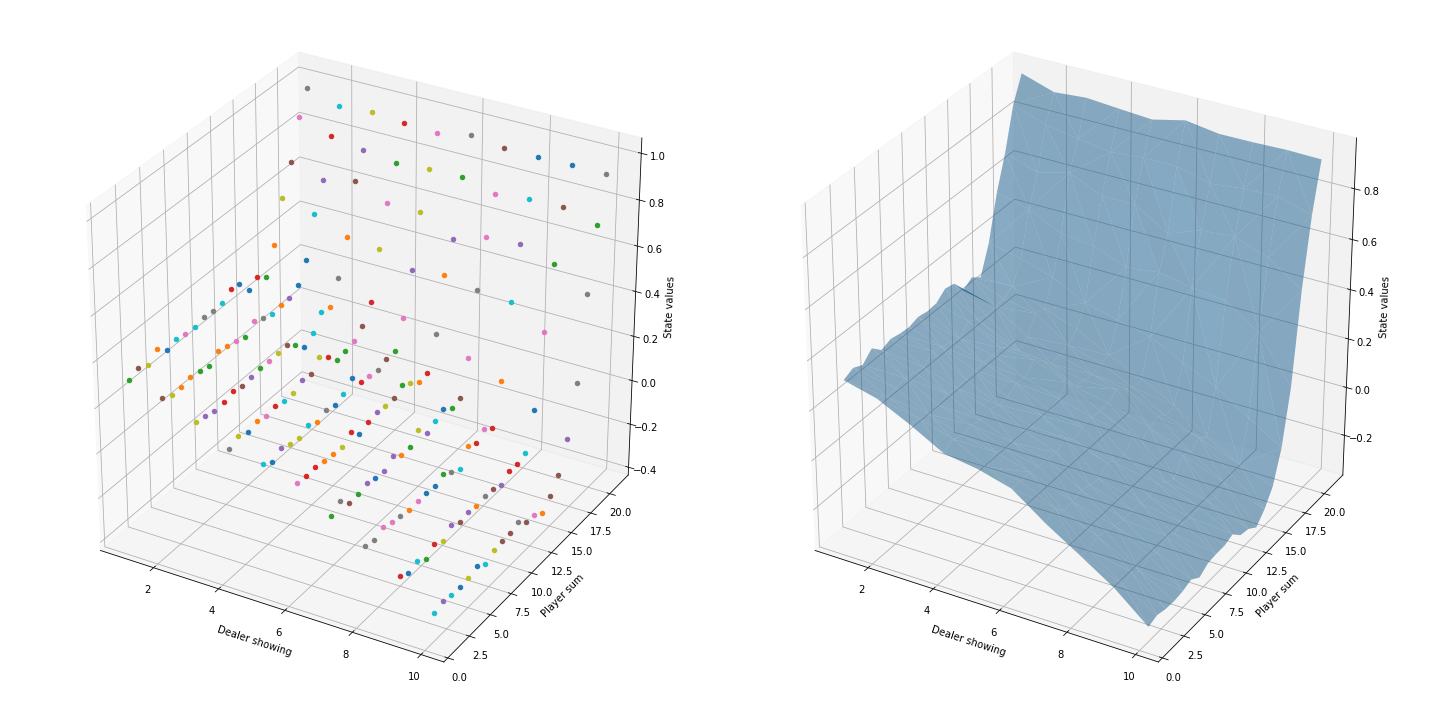

In [9]:
print("Optimal policy for the restricted case on first-visit MC:")
draw_scatter_trisurf(mc_V)

Now every-visit:

Optimal policy for the restricted case on every-visit MC:


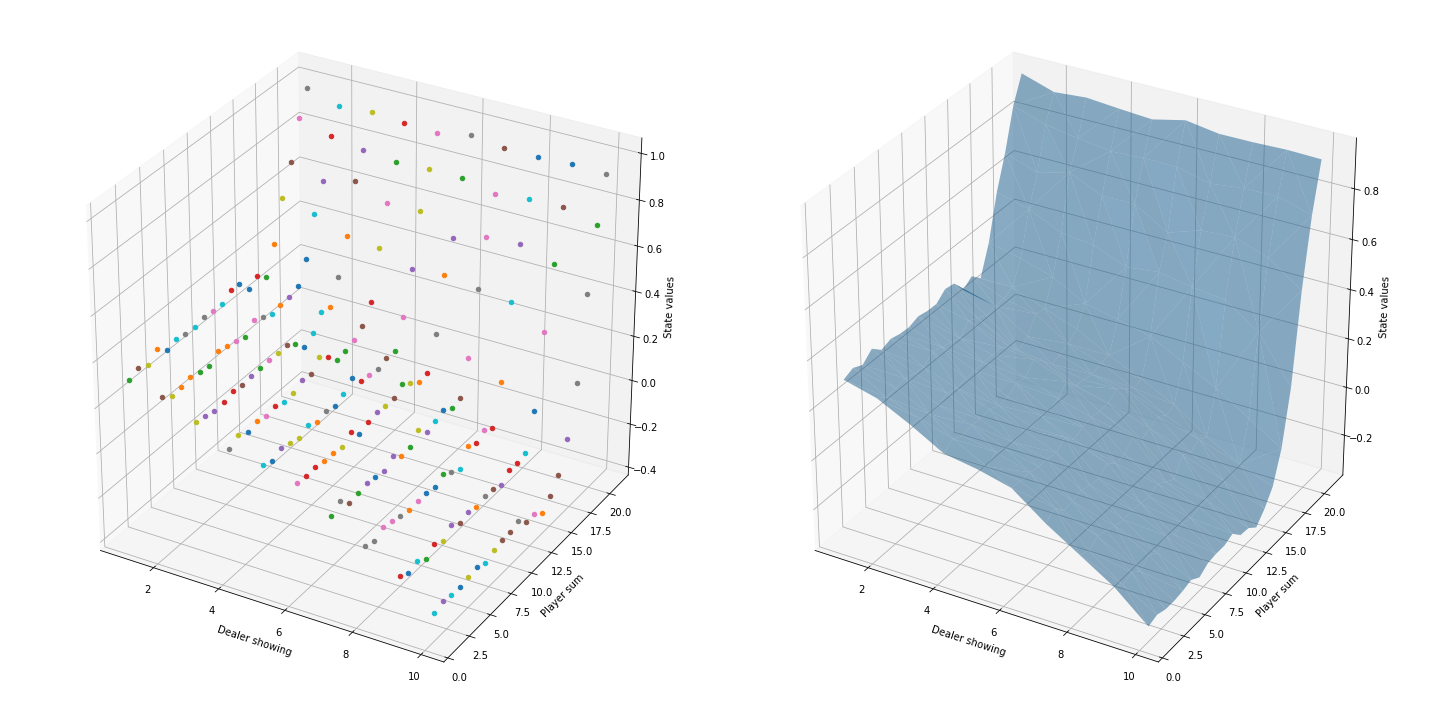

In [10]:
print("Optimal policy for the restricted case on every-visit MC:")
draw_scatter_trisurf(mc_e_V)

Now let's see the optimum policies for the more general case (when negative initial cards are valid).

Computing first-visit unrestricted MC...


Number of episodes: 100


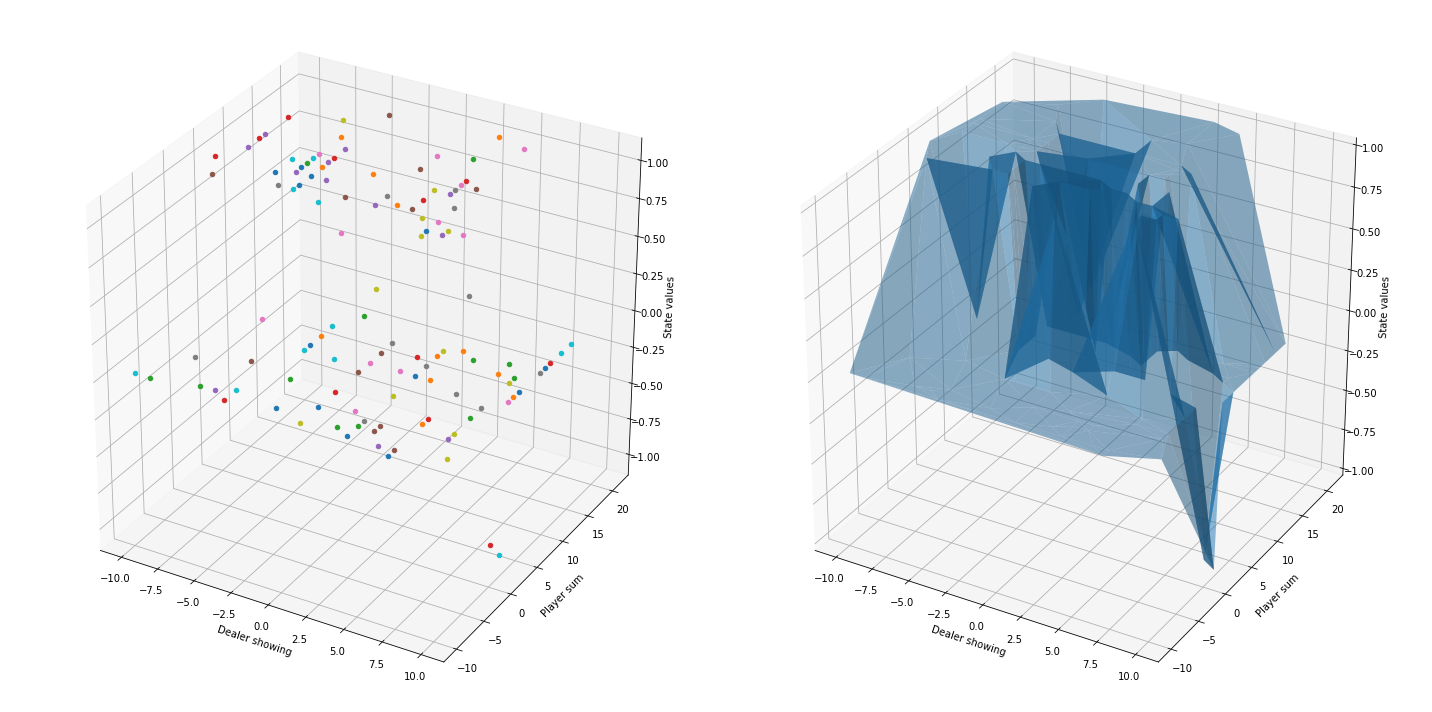

Number of episodes: 1000


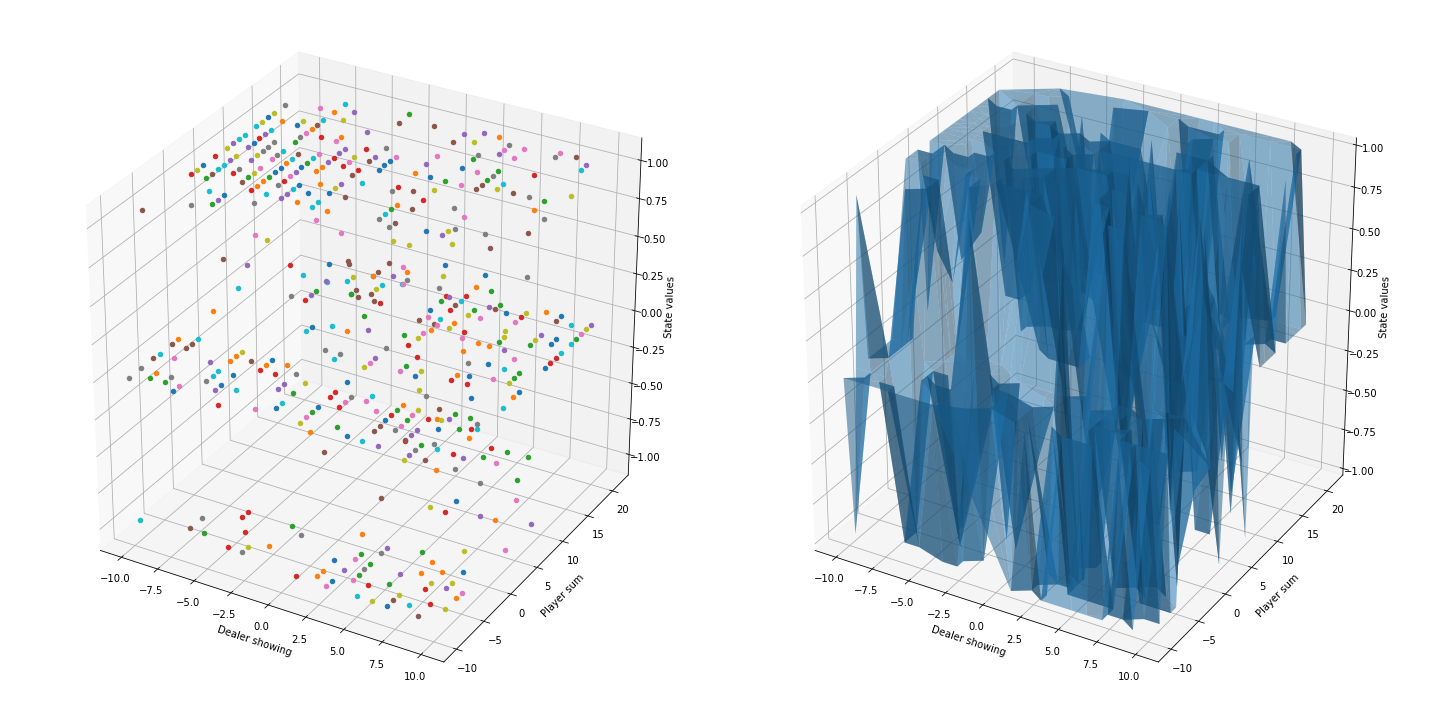

Number of episodes: 10000


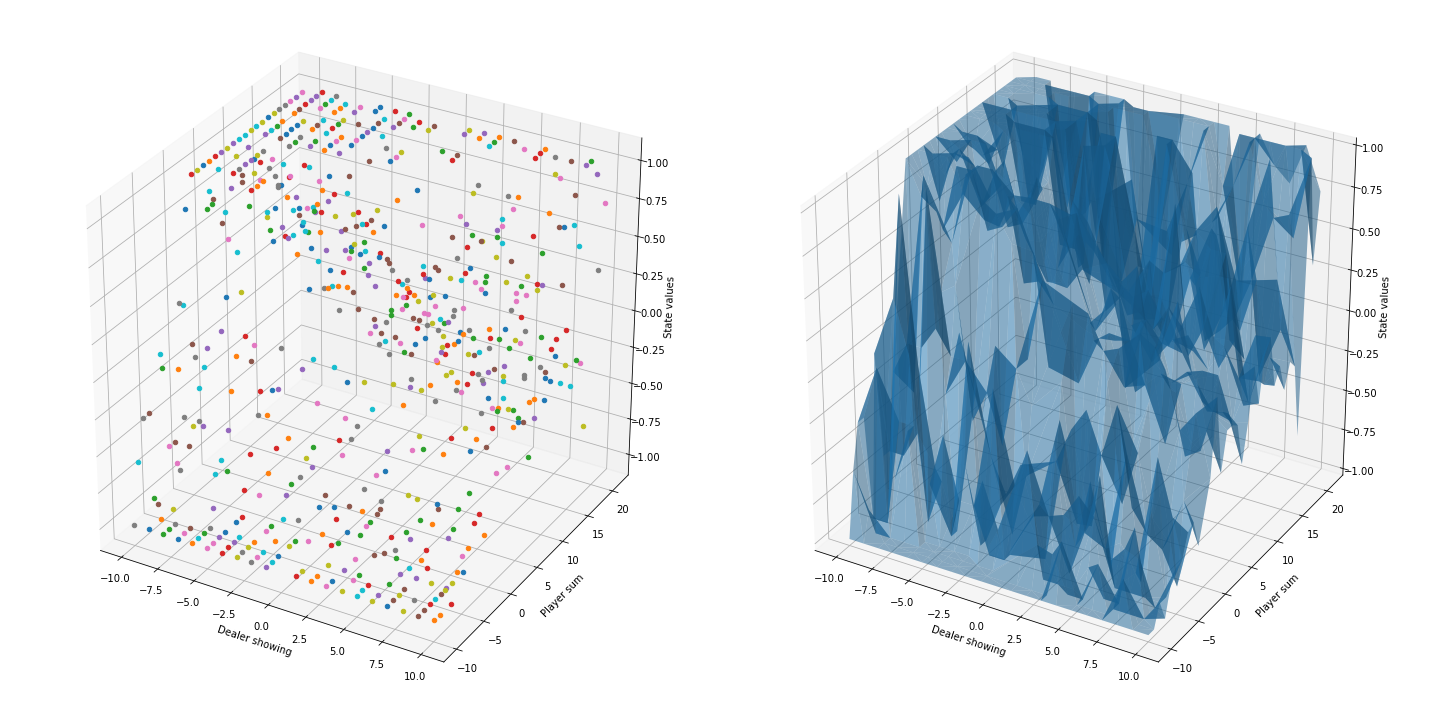

Number of episodes: 100000


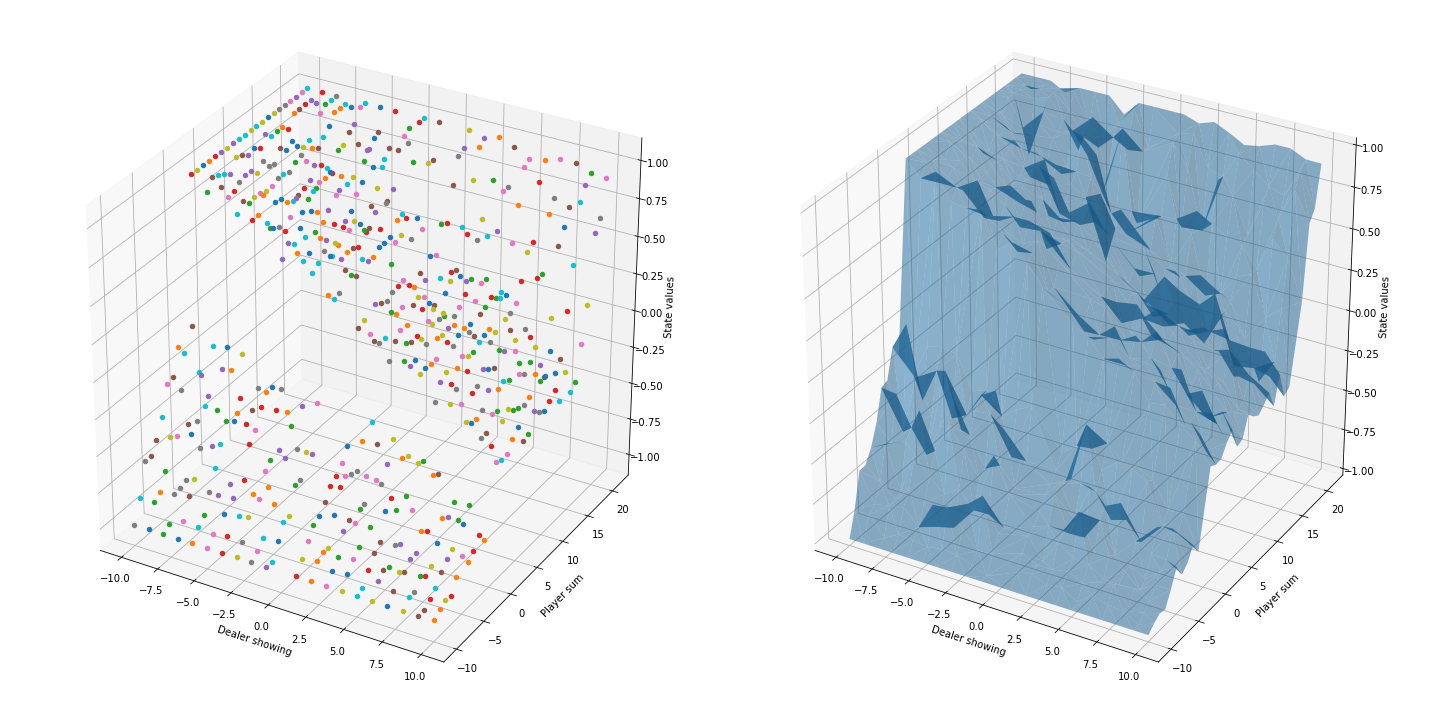


Optimal policy for the unrestricted case on first-visit MC:


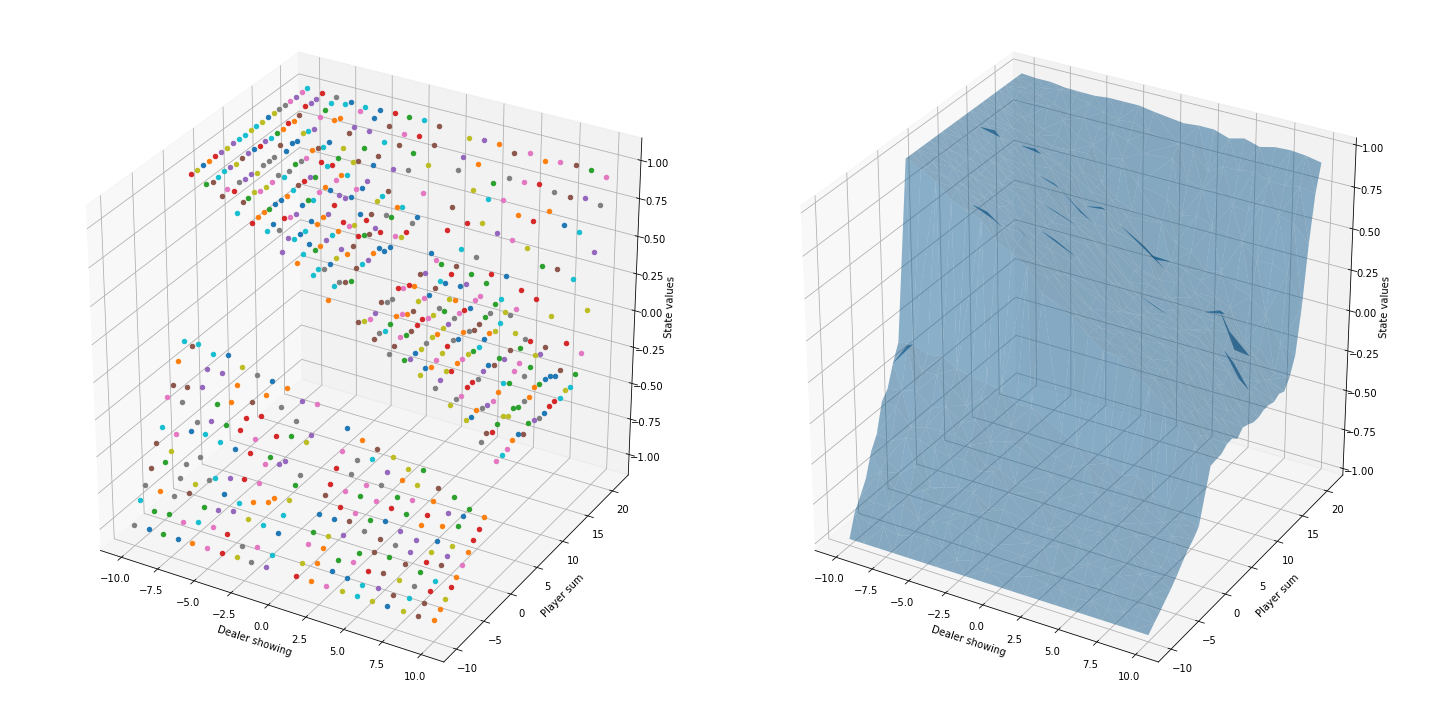

Computing every-visit unrestricted MC...


Number of episodes: 100


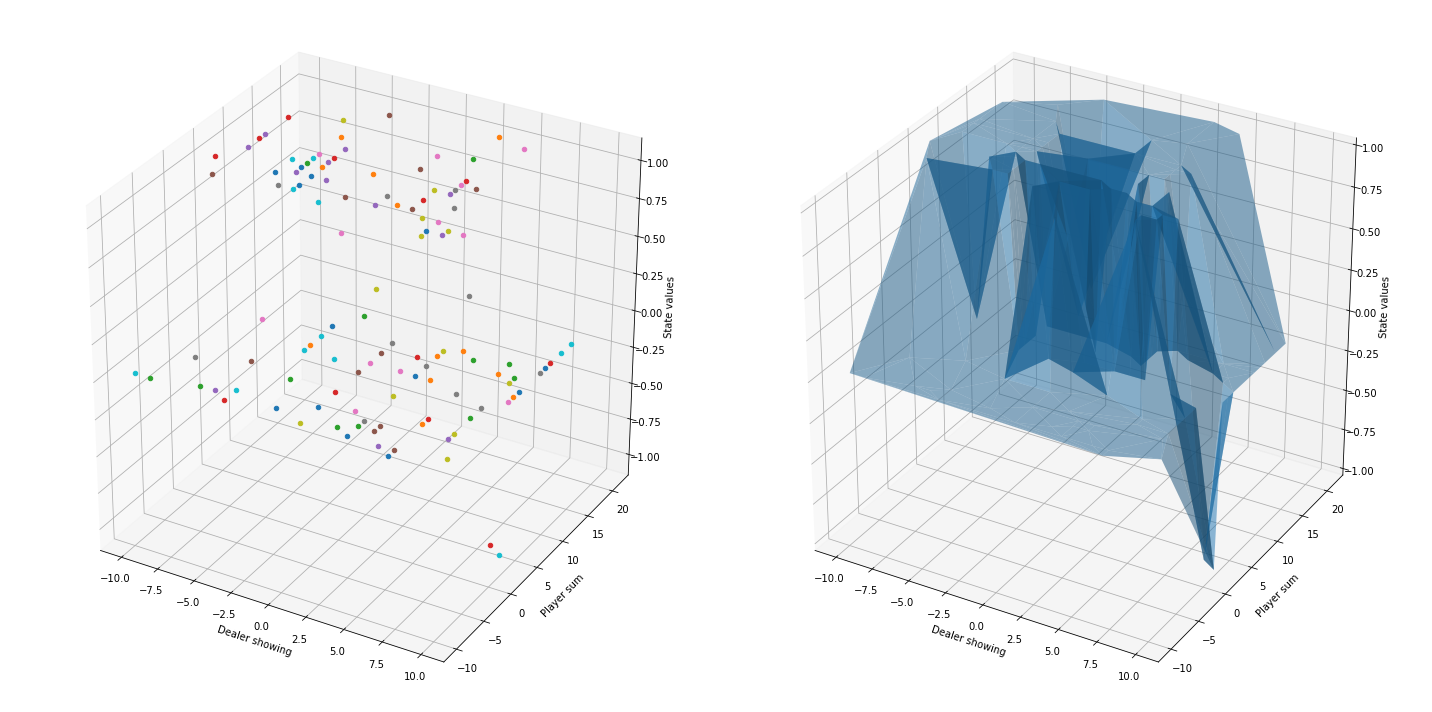

Number of episodes: 1000


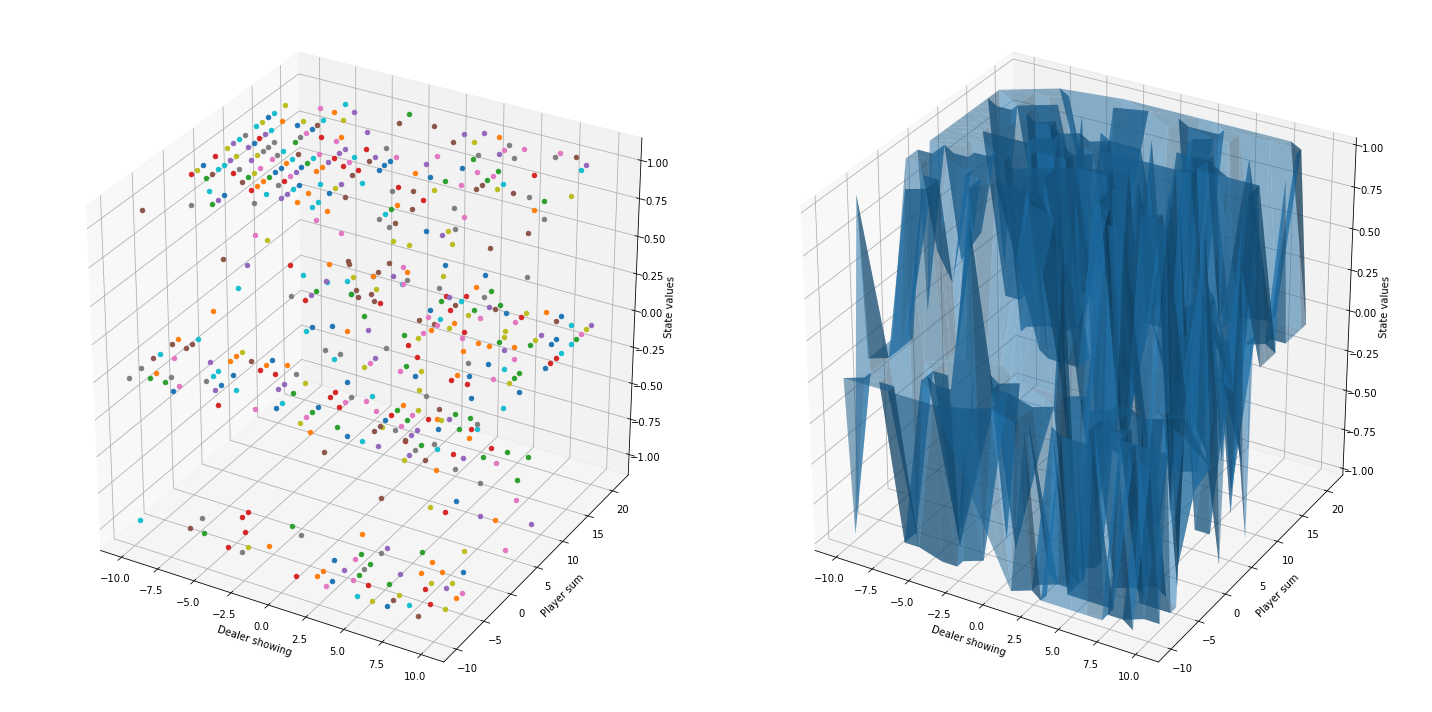

Number of episodes: 10000


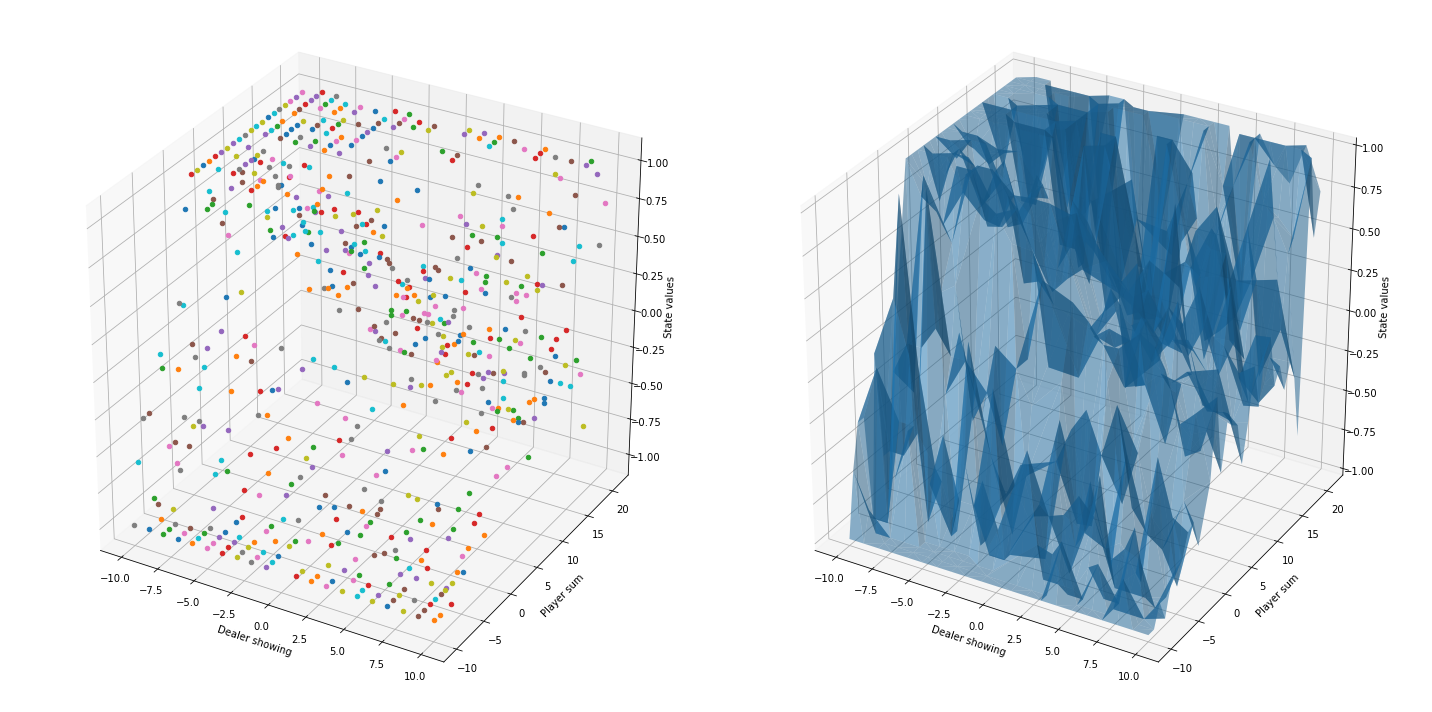

Number of episodes: 100000


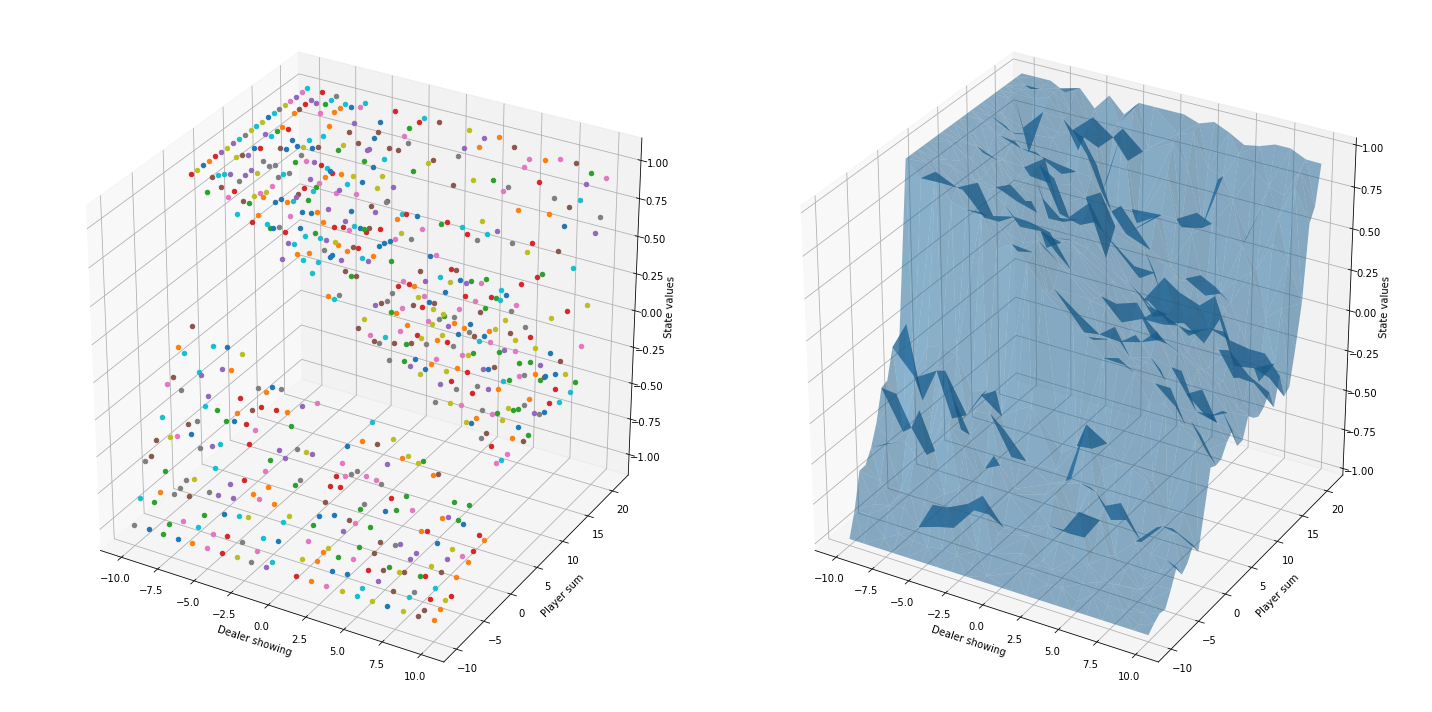


Optimal policy for the unrestricted case on every-visit MC:


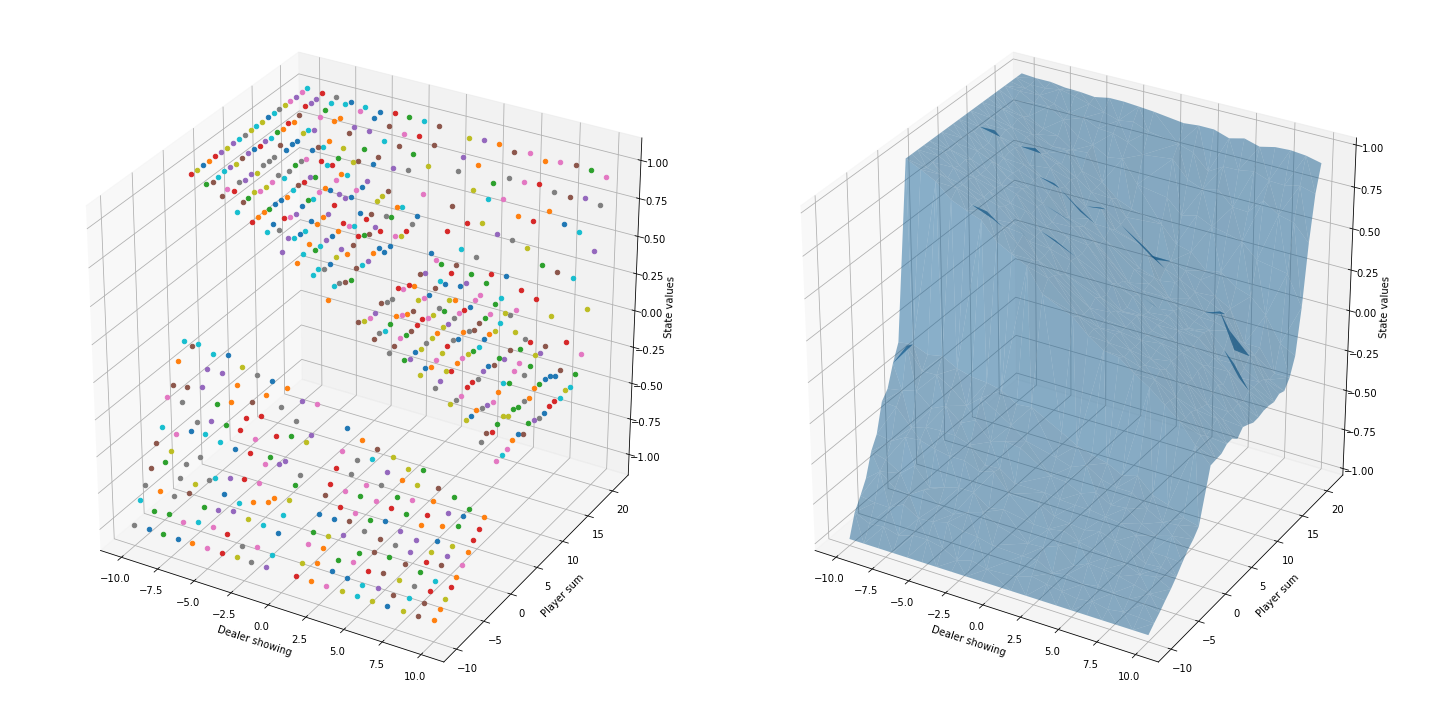

In [11]:
print('Computing first-visit unrestricted MC...')
mc_a_Q = mc_control(MC_N, restrict=False, foreach=plot_at_each)
mc_a_V = extract_max_V(mc_a_Q)

print("Optimal policy for the unrestricted case on first-visit MC:")
draw_scatter_trisurf(mc_a_V)

print('Computing every-visit unrestricted MC...')
mc_a_e_Q = mc_control(MC_N, mode='every', restrict=False, foreach=plot_at_each)
mc_a_e_V = extract_max_V(mc_a_e_Q)

print("Optimal policy for the unrestricted case on every-visit MC:")
draw_scatter_trisurf(mc_a_e_V)

Notice how we can clearly see the restricted case subset in the above graphs.

#### Sarsa($\lambda$)

In [15]:
def extract_max_V_matrix(Q, I):
    V = defaultdict(float)
    for h, i in I.items():
        V[h] = np.max(Q[i])
    return V

def plot_at_each_matrix(n, Q, I):
    if n == 100 or n == 1000 or n == 10000 or n == 100000:
        print("Number of episodes: {:}".format(n))
        draw_scatter_trisurf(extract_max_V_matrix(Q, I))

# Sarsa(lambda) control
#   lambda   - lambda parameter
#   n        - number of episodes to run
#   gamma    - discount rate
#   restrict - whether 
def sarsa(l, n=1000, gamma=1, restrict=True, foreach=None):
    np.random.seed(RAND_SEED)
    pi = defaultdict(lambda: [0.35, 0.65])
    I = {}
    Q = np.zeros((State.NumberStates(), len(ACTIONS)))
    E = np.zeros((State.NumberStates(), len(ACTIONS)))
    N = np.ones((State.NumberStates(), len(ACTIONS)))
    M = defaultdict(int)
    j = 0
    
    for i in tnrange(n, desc="Progress"):
        s = State.Restricted() if restrict else State.Unrestricted()
        a = sample_action(s, pi)
        while not s.t:
            r, n_s = STEP(s, a)
            h, n_h = hash(s), hash(n_s)
            n_a = sample_action(n_s, pi)
            if h not in I:
                I[h] = j
                j += 1
            if n_h not in I:
                I[n_h] = j
                j += 1
            d = r+gamma*Q[I[n_h],n_a]-Q[I[h],a]
            E[I[h],a] += 1
            Q += d*E/N
            E *= gamma*l
            N[I[h],a] += 1
            M[h] += 1
            eps = N_0/(N_0+M[h])
            a_o = np.argmax(Q[I[h]])
            p_o = 1.0-eps/2
            p_no = 1.0-p_o
            for a_i in ACTIONS:
                pi[h][a_i] = p_o if a_i == a_o else p_no
            s, a = n_s, n_a
        if foreach is not None:
            foreach(i, Q, I)
    return Q, I

sarsa_Q = []
sarsa_a_Q = []
mse, mse_a = [], []
for i in tnrange(11, desc="Lambda"):
    l = i/10.0
    print("Computing restricted SARSA({:})".format(l))
    sarsa_Q.append(sarsa(l, 100000))#, foreach=plot_at_each_matrix))
    mse 
    print("Computing unrestricted SARSA({:})".format(l))
    sarsa_a_Q.append(sarsa(l, 100000, restrict=False))#, foreach=plot_at_each_matrix))

Computing restricted SARSA(0.0)


Computing unrestricted SARSA(0.0)


Computing restricted SARSA(0.1)


Computing unrestricted SARSA(0.1)


Computing restricted SARSA(0.2)


Computing unrestricted SARSA(0.2)


Computing restricted SARSA(0.3)


Computing unrestricted SARSA(0.3)


Computing restricted SARSA(0.4)


Computing unrestricted SARSA(0.4)


Computing restricted SARSA(0.5)


Computing unrestricted SARSA(0.5)


Computing restricted SARSA(0.6)


Computing unrestricted SARSA(0.6)


Computing restricted SARSA(0.7)


Computing unrestricted SARSA(0.7)


Computing restricted SARSA(0.8)


Computing unrestricted SARSA(0.8)


Computing restricted SARSA(0.9)


Computing unrestricted SARSA(0.9)


Computing restricted SARSA(1.0)


Computing unrestricted SARSA(1.0)


We computed SARSA($\lambda$) for $\lambda\in\{0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0\}$. We now draw the mean-squared error for each $\lambda$ and compare values with Monte-Carlo's optimal $Q_\ast$.

Restricted SARSA(lambda):


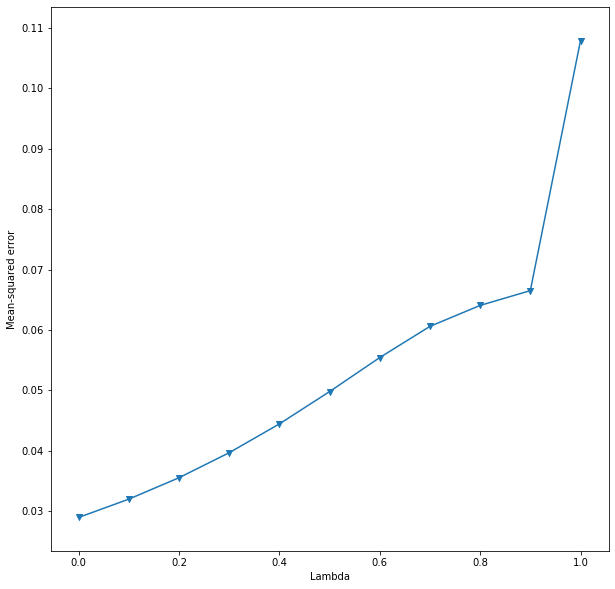

Unrestricted SARSA(lambda):


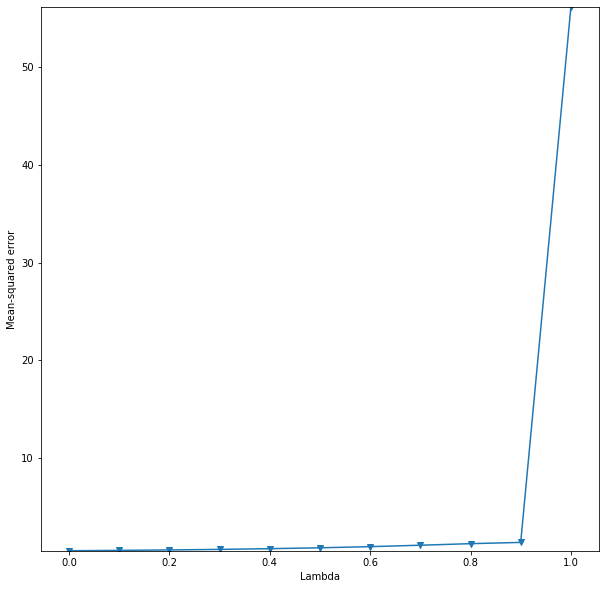

Restricted SARSA(lambda) by episodes for lambda in {0, 1}:


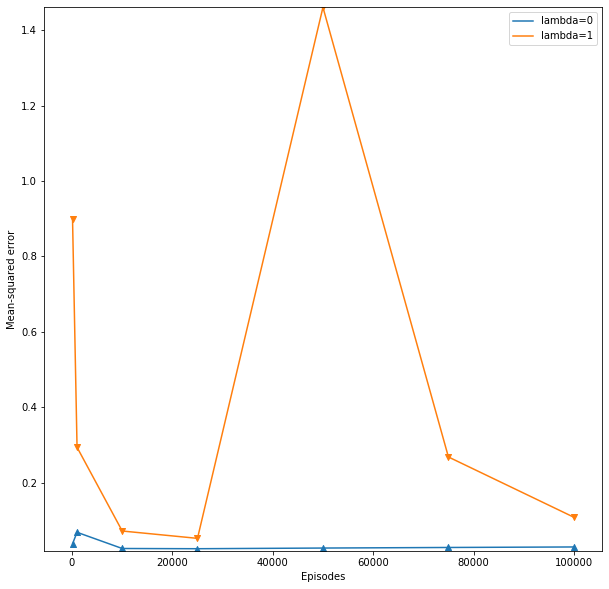

Unestricted SARSA(lambda) by episodes for lambda in {0, 1}:


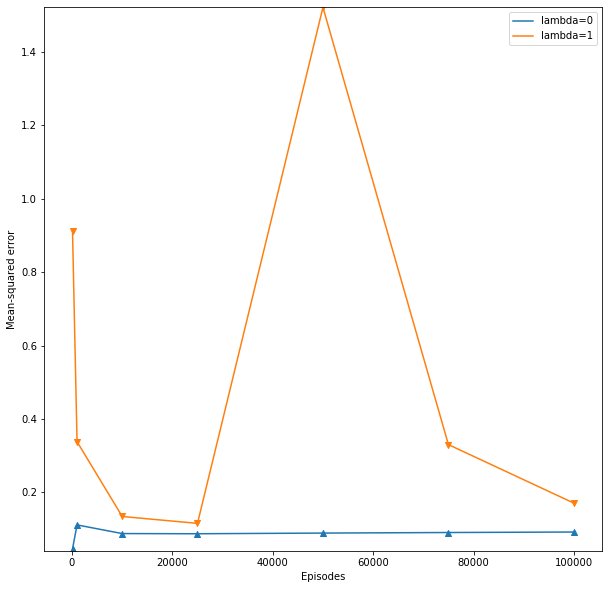

In [40]:
def draw_mse(C, Q_o, by='lambda'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    E, L = [], []
    if by == 'lambda':
        for l, P in enumerate(C):
            Q, I = P[0], P[1]
            M = Q.copy()
            for h in Q_o:
                M[I[h]] = Q_o[h]
            E.append(np.square(M-Q).mean())
            L.append(l/10.0)
        ax.set_xlabel('Lambda')
        ax.set_ylabel('Mean-squared error')
    else: # by episode number.
        def mse_episode(n, _Q, _I):
            nonlocal E
            nonlocal L
            nonlocal Q_o
            if n == 100 or n == 1000 or n == 10000 or n == 25000 or n == 50000 or n == 75000 or n == 99999:
                M = _Q.copy()
                for h in Q_o:
                    if h in _I:
                        M[_I[h]] = Q_o[h]
                E.append(np.square(M-_Q).mean())
                L.append(n)
        sarsa(0, 100000, foreach=mse_episode)
        sarsa(1, 100000, foreach=mse_episode)
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Mean-squared error')
        _L, _E = L[:7], E[:7]
        ax.scatter(_L, _E, marker='^')
        ax.plot(_L, _E)
        L, E = L[7:], E[7:]
    ax.scatter(L, E, marker='v')
    ax.plot(L, E)
    plt.gca().autoscale(enable=True, axis='y', tight=True)
    if by != 'lambda':
        plt.gca().legend(('lambda=0', 'lambda=1'))
    plt.show()
    
print("Restricted SARSA(lambda):")
draw_mse(sarsa_Q, mc_Q)
print("Unrestricted SARSA(lambda):")
draw_mse(sarsa_a_Q, mc_a_Q)
print("Restricted SARSA(lambda) by episodes for lambda in {0, 1}:")
draw_mse(sarsa_Q, mc_Q, by='episode')
print("Unestricted SARSA(lambda) by episodes for lambda in {0, 1}:")
draw_mse(sarsa_a_Q, mc_a_Q, by='episode')

For $\lambda=0$ and $\lambda=1$, we also plot MSE by number of episodes.